In [1]:
import tensorflow as tf
import input_data
import numpy as np
import random

In [2]:
hidden_size = 100

In [3]:
def get_weights(shape, interval):
    val = np.random.uniform(-interval, interval, size=shape)
    val = np.cast['float32'](val)
    
    return tf.Variable(val)

def get_bias(shape, offset=0):
    val = np.zeros(shape) - offset
    val = np.cast['float32'](val)
    
    return tf.Variable(val)

In [4]:
def binomial_draw(shape=[1], p=0.5, dtype='float32'):
    return tf.select(tf.less(tf.random_uniform(shape=shape, minval=0, maxval=1, dtype='float32'), tf.fill(shape, p)), tf.ones(shape, dtype=dtype), tf.zeros(shape, dtype=dtype))

In [5]:
def add_noise(tensor, rate=0.2):
    # Salt and pepper noise
    a = binomial_draw(shape=tf.shape(tensor), p=1-rate, dtype='float32')
    b = binomial_draw(shape=tf.shape(tensor), p=0.5, dtype='float32')
    z = tf.zeros(tf.shape(tensor), dtype='float32')
    c = tf.select(tf.equal(a, z), b, z)
    
    return tf.add(tf.mul(tensor, a), c)

Input

In [6]:
input_ = tf.placeholder(tf.float32, [None, 784])

Model

In [7]:
# Binarize input
binarized_input = tf.floor(tf.add(input_, tf.fill(tf.shape(input_), 0.5)))

# Add noise to input
noised_input = add_noise(binarized_input)

# Input layer to hidden layer
W1 = get_weights([784, hidden_size], np.sqrt(6. / (784 + hidden_size)))
b1 = get_bias([hidden_size])

# Hidden layer to output layer
W2 = get_weights([hidden_size, 784], np.sqrt(6. / (784 + hidden_size)))
b2 = get_bias([784])

# Activations
hidden = tf.sigmoid(tf.matmul(noised_input, W1) + b1)
output = tf.sigmoid(tf.matmul(hidden, W2) + b2)

Loss and Optimizer

In [8]:
# Loss
clipped_output         = tf.clip_by_value(output, 1e-10, 1.0)
clipped_1_minus_output = tf.clip_by_value(1 - output, 1e-10, 1.0)

loss = -tf.reduce_sum(input_ * tf.log(clipped_output) + (1 - input_) * tf.log(clipped_1_minus_output))

In [9]:
# Optimizer
train_op = tf.train.AdamOptimizer().minimize(loss)

Get some data

In [10]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Validation split
valid_ratio = float(10)/55
train_pairs = zip(mnist.train.images, mnist.train.labels)
random.shuffle(train_pairs)
train_X, train_Y = zip(*train_pairs[int(valid_ratio*len(train_pairs)):])
valid_X, valid_Y = zip(*train_pairs[:int(valid_ratio*len(train_pairs))])

# Test pairs
test_X, test_Y = mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
print 'Training:', len(train_X)
print 'Validation:', len(valid_X)
print 'Test:', len(test_X)

Training: 45000
Validation: 10000
Test: 10000


Training

In [12]:
batch_size = 64

In [13]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(20):
    train_loss = []
    valid_loss = []
    test_loss  = []

    for j in range(len(train_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, _ = sess.run([loss, train_op], feed_dict={input_: train_X[start:end]})

        train_loss.append(loss_/(batch_size * 784))

    for j in range(len(valid_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_ = sess.run(loss, feed_dict={input_: valid_X[start:end]})

        valid_loss.append(loss_/(batch_size * 784))

    for j in range(len(test_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_ = sess.run(loss, feed_dict={input_: test_X[start:end]})

        test_loss.append(loss_/(batch_size * 784))

    print 'End of epoch %d:' % (i+1)
    print 'Training loss:', np.mean(train_loss), \
          'Validation loss:', np.mean(valid_loss), \
          'Test loss:', np.mean(test_loss)
    print

End of epoch 1:
Training loss: 0.270948203641 Validation loss: 0.255506187506 Test loss: 0.254061198122

End of epoch 2:
Training loss: 0.23578257451 Validation loss: 0.218055140217 Test loss: 0.21670497518

End of epoch 3:
Training loss: 0.203824126164 Validation loss: 0.193788139312 Test loss: 0.192402676473

End of epoch 4:
Training loss: 0.186367314907 Validation loss: 0.180409760577 Test loss: 0.179038624811

End of epoch 5:
Training loss: 0.174867935623 Validation loss: 0.170191352122 Test loss: 0.16881127622

End of epoch 6:
Training loss: 0.165865578271 Validation loss: 0.16247745461 Test loss: 0.16100752728

End of epoch 7:
Training loss: 0.159458080376 Validation loss: 0.157174416077 Test loss: 0.155568129913

End of epoch 8:
Training loss: 0.154738886421 Validation loss: 0.152957961486 Test loss: 0.151414421701

End of epoch 9:
Training loss: 0.151063823747 Validation loss: 0.149721278376 Test loss: 0.148173181129

End of epoch 10:
Training loss: 0.148090271174 Validation lo

# Demonstration

In [14]:
from matplotlib.pyplot import imshow

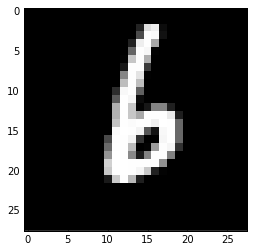

In [15]:
%matplotlib inline
# Input
this_input = random.sample(test_X, 1)[0]
imshow(np.reshape(this_input, (28, 28)), interpolation='none', cmap='Greys_r')

In [16]:
# Get output
this_noised_input, this_output = sess.run([noised_input, output], feed_dict={input_: [this_input]})

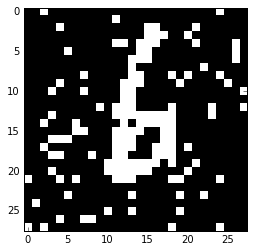

In [17]:
%matplotlib inline
# Noised input
imshow(np.reshape(this_noised_input, (28, 28)), interpolation='nearest', cmap='Greys_r')

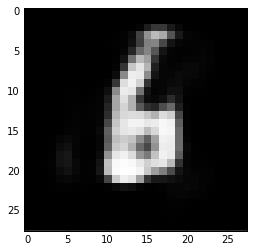

In [18]:
%matplotlib inline
# Output
imshow(np.reshape(this_output, (28, 28)), interpolation='none', cmap='Greys_r')